In [1]:
import sqlite3
import pandas as pd
from sqlalchemy import create_engine

In [3]:
#msqlite db 연결
engine = create_engine('sqlite:///waterpoint.db', convert_unicode=True)
conn = engine.connect()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31272\2302449939.py:2: SADeprecationWarning: The create_engine.convert_unicode parameter and corresponding dialect-level parameters are deprecated, and will be removed in a future release.  Modern DBAPIs support Python Unicode natively and this parameter is unnecessary.
  engine = create_engine('sqlite:///waterpoint.db', convert_unicode=True)


In [4]:
#pandas를 통해 table 읽어오기
df = pd.read_sql_table('waterpoint_model', conn)

In [5]:
df

,id,amount_tsh,construction_year,extraction_type,source_type,waterpoint_type,management,payment_type,quality,quantity,populaion,public_meeting,status
0,69572,6000.0,1990s,gravity,spring,communal standpipe,user-group,annually,good,enough,less 500,True,functional
1,8776,0.0,2010s,gravity,rainwater harvesting,communal standpipe,user-group,never pay,good,insufficient,less 500,unknown,functional
2,34310,25.0,2000s,gravity,dam,communal standpipe,user-group,per bucket,good,enough,less 500,True,functional
3,67743,0.0,1980s,submersible,borehole,communal standpipe,user-group,never pay,good,dry,less 100,True,non functional
4,19728,0.0,unknown,gravity,rainwater harvesting,communal standpipe,other,never pay,good,seasonal,less 100,True,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,1990s,gravity,spring,communal standpipe,user-group,per bucket,good,enough,less 500,True,functional
59396,27263,4700.0,1990s,gravity,river/lake,communal standpipe,user-group,annually,good,enough,less 100,True,functional
59397,37057,0.0,unknown,swn 80,borehole,hand pump,user-group,monthly,fluoride,enough,less 100,True,functional
59398,31282,0.0,unknown,nira/tanira,shallow well,hand pump,user-group,never pay,good,insufficient,less 100,True,functional


In [6]:
import matplotlib.pyplot as plt

def analysis_on_target(df):
    
    n_func_label, n_nonfunc_label, n_repair_label = (df['status'] == 'functional').sum(), (df['status'] == 'non functional').sum(), (df['status'] == 'functional needs repair').sum()

    plt.pie(
        (n_func_label, n_nonfunc_label, n_repair_label),
        labels=('functional', 'non functional', 'functional needs repair'),
        autopct="%.2f%%",
        shadow=True,
        startangle=90,)
    plt.title("Target: Status", size=15)
    plt.show()

    return n_func_label, n_nonfunc_label, n_repair_label

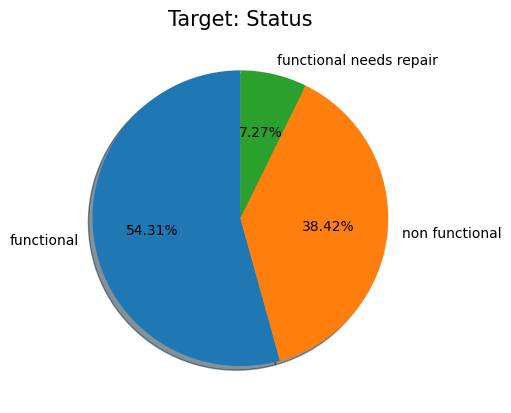

(32259, 22824, 4317)

In [7]:
analysis_on_target(df)

In [8]:
#데이터를 train과 validation, test데이터로 나눠줌
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.80, test_size=0.20, stratify=df['status'], random_state=2)
train, val = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train['status'], random_state=2)

print("train set : ",train.shape)
print("validation set : ",val.shape)
print("test set : ",test.shape)

train set :  (38016, 13)
validation set :  (9504, 13)
test set :  (11880, 13)


In [9]:
#데이터를 X,y로 분리
target = 'status'
features = df.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [10]:
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.distributions import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve

In [11]:
#LightGBM 모델
from lightgbm import LGBMClassifier

pipe_lgb = make_pipeline(
    OrdinalEncoder(),
    LGBMClassifier(objective ='multiclass',
                   num_class=3,learning_rate= 0.1,
                   num_leaves= 100, max_depth= 50, min_data_in_leaf=5,
                   feature_fraction= 0.5, bagging_fraction= 0.8, bagging_freq= 7,
                   boosting_type= 'gbdt', random_state=29,
                   class_weight = 'balanced'))

pipe_lgb.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['construction_year', 'extraction_type',
                                      'source_type', 'waterpoint_type',
                                      'management', 'payment_type', 'quality',
                                      'quantity', 'populaion',
                                      'public_meeting'],
                                mapping=[{'col': 'construction_year',
                                          'data_type': dtype('O'),
                                          'mapping': unknown    1
2000s      2
1990s      3
2010s      4
1970s      5
1980s      6
1960s      7
NaN       -2
dtype: int64},
                                         {'col': 'extract...
less 10,000    5
less 50,000    6
NaN           -2
dtype: int64},
                                         {'col': 'public_meeting',
                                          'data_type': dtype('O'),
                                          'mapping': True       1
unknown    2
False      3
NaN       -2
dtype: int64}])),
                ('lgbmclassifier',
                 LGBMClassifier(bagging_fraction=0.8, bagging_freq=7,
                                class_weight='balanced', feature_fraction=0.5,
                                max_depth=50, min_data_in_leaf=5, num_class=3,
                                num_leaves=100, objective='multiclass',
                                random_state=29))])

In [12]:
print("훈련 정확도: ", pipe_lgb.score(X_train, y_train))
print("검증 정확도: ", pipe_lgb.score(X_val, y_val))

훈련 정확도:  0.733822601010101
검증 정확도:  0.6596170033670034


In [13]:
y_pred5 = pipe_lgb.predict(X_val)
print(classification_report(y_val, y_pred5))

                         precision    recall  f1-score   support

             functional       0.78      0.68      0.72      5161
functional needs repair       0.18      0.54      0.28       691
         non functional       0.81      0.66      0.73      3652

               accuracy                           0.66      9504
              macro avg       0.59      0.63      0.57      9504
           weighted avg       0.75      0.66      0.69      9504



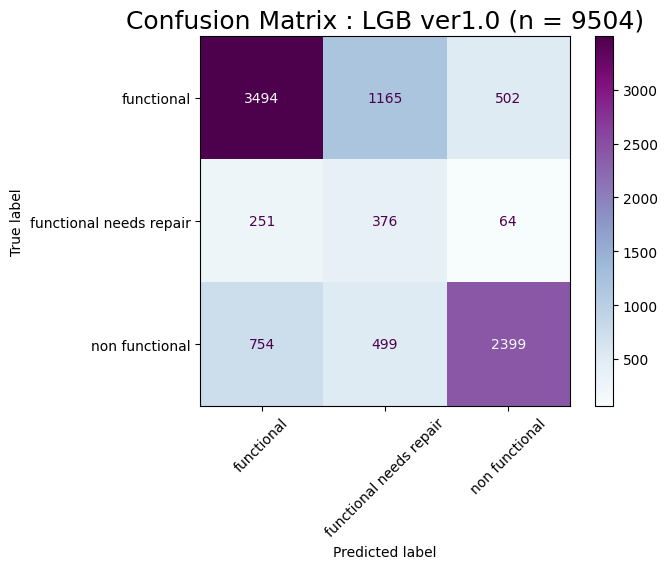

In [14]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred5, cmap=plt.cm.BuPu)
plt.title(f"Confusion Matrix : LGB ver1.0 (n = {len(y_val)})", fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [15]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe_lgb.named_steps["lgbmclassifier"],
    scoring="accuracy",
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=29,)

# 스코어를 다시 계산합니다.
X_val_preprocessed = pipe_lgb[0].transform(X_val)
permuter.fit(X_val_preprocessed, y_val)

PermutationImportance(estimator=LGBMClassifier(bagging_fraction=0.8,
                                               bagging_freq=7,
                                               class_weight='balanced',
                                               feature_fraction=0.5,
                                               max_depth=50, min_data_in_leaf=5,
                                               num_class=3, num_leaves=100,
                                               objective='multiclass',
                                               random_state=29),
                      n_iter=10, random_state=29, scoring='accuracy')

Text(0.5, 1.0, 'Permutation Importance')

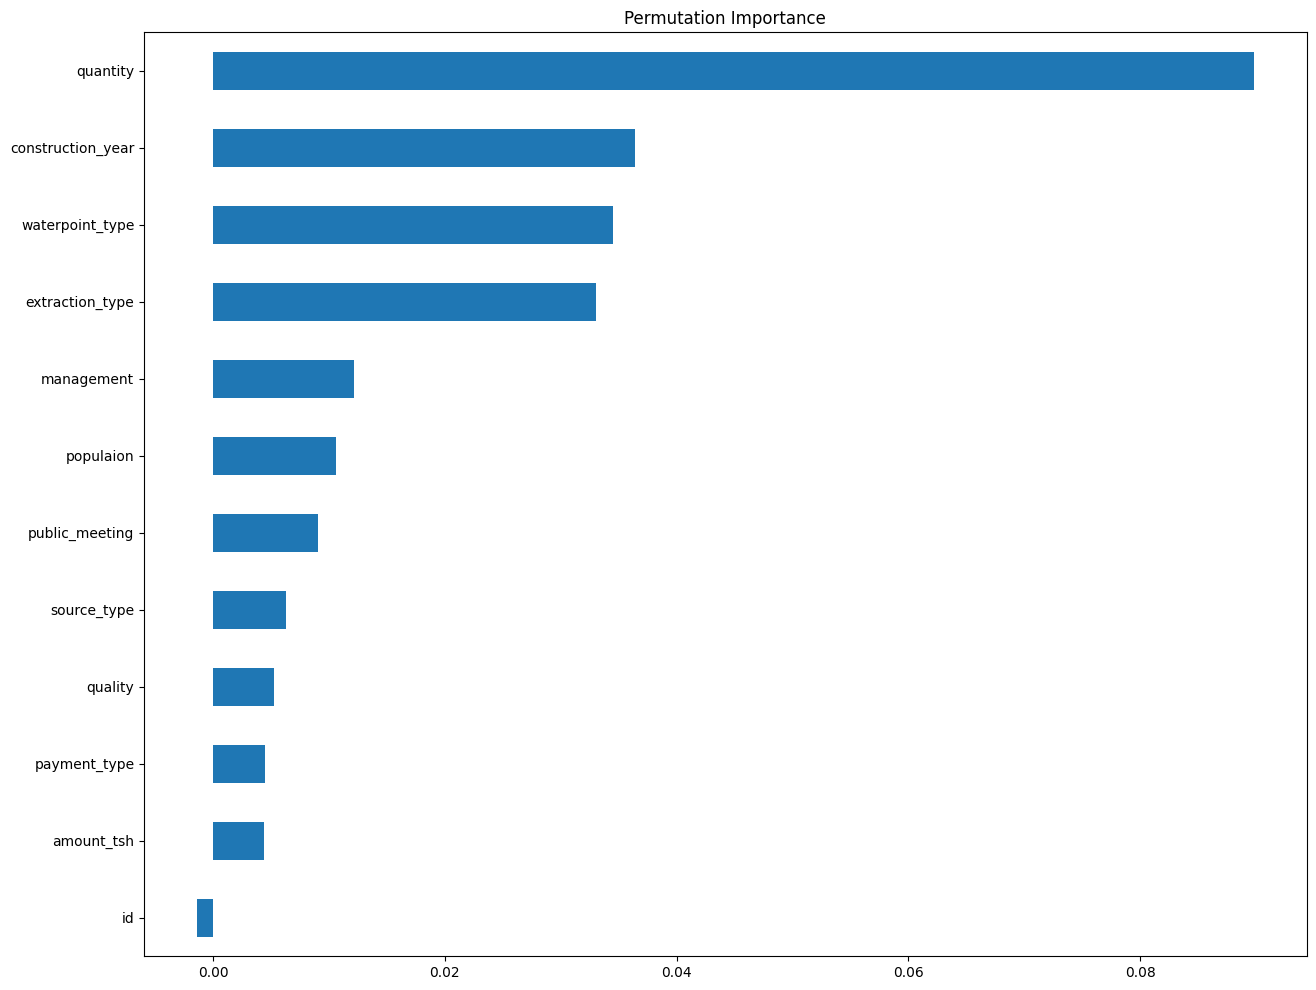

In [16]:
feature_names = X_val.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
plt.figure(figsize=(15,12))
pi.plot.barh()
plt.title("Permutation Importance")

In [17]:
y_pred_final = pipe_lgb.predict(X_test)
print(classification_report(y_test, y_pred_final))

                         precision    recall  f1-score   support

             functional       0.78      0.69      0.73      6452
functional needs repair       0.18      0.52      0.27       863
         non functional       0.81      0.66      0.73      4565

               accuracy                           0.67     11880
              macro avg       0.59      0.62      0.58     11880
           weighted avg       0.75      0.67      0.70     11880



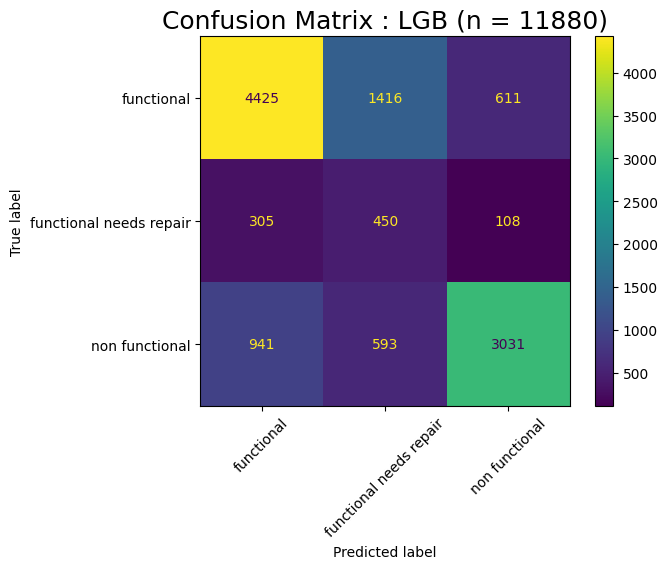

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, cmap=plt.cm.viridis)
plt.title(f"Confusion Matrix : LGB (n = {len(y_test)})", fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [19]:
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe_lgb.named_steps["lgbmclassifier"],
    scoring="accuracy",
    n_iter=10,  # 다른 random seed를 사용하여 10번 반복
    random_state=29,)

# 스코어를 다시 계산합니다.
X_test_preprocessed = pipe_lgb[0].transform(X_test)
permuter.fit(X_test_preprocessed, y_test)

PermutationImportance(estimator=LGBMClassifier(bagging_fraction=0.8,
                                               bagging_freq=7,
                                               class_weight='balanced',
                                               feature_fraction=0.5,
                                               max_depth=50, min_data_in_leaf=5,
                                               num_class=3, num_leaves=100,
                                               objective='multiclass',
                                               random_state=29),
                      n_iter=10, random_state=29, scoring='accuracy')

Text(0.5, 1.0, 'Permutation Importance')

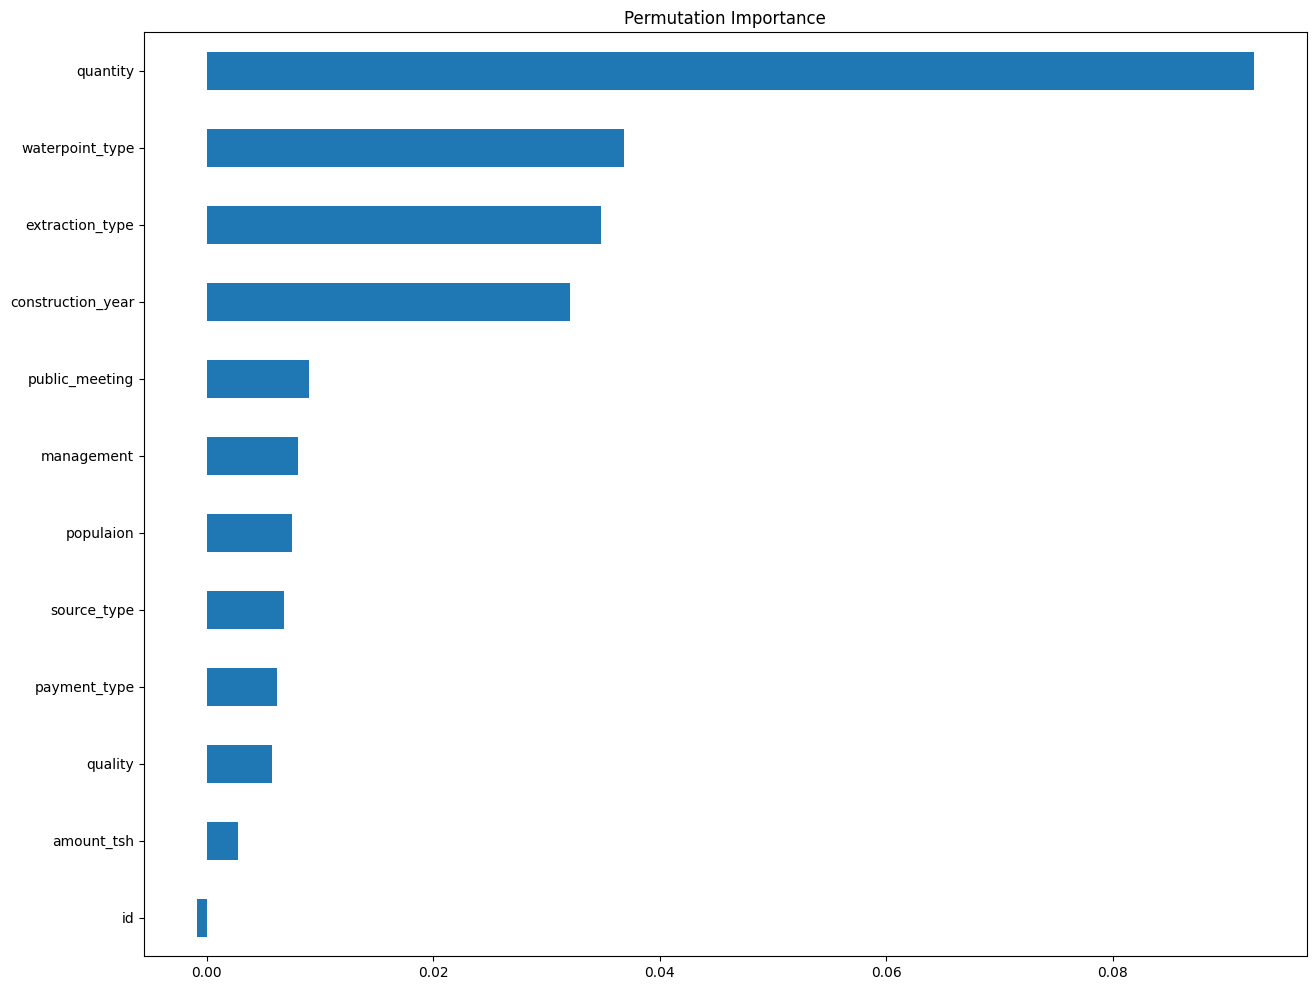

In [20]:
feature_names = X_test.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
plt.figure(figsize=(15,12))
pi.plot.barh()
plt.title("Permutation Importance")

In [21]:
# 특성별 score을 확인
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names,)

Weight,Feature
0.0925 ± 0.0064,quantity
0.0368 ± 0.0052,waterpoint_type
0.0348 ± 0.0046,extraction_type
0.0321 ± 0.0050,construction_year
0.0090 ± 0.0026,public_meeting
0.0080 ± 0.0022,management
0.0076 ± 0.0026,populaion
0.0068 ± 0.0022,source_type
0.0062 ± 0.0042,payment_type
0.0057 ± 0.0026,quality


In [22]:
import pickle
with open('model.pkl','wb') as pickle_file:
    pickle.dump(pipe_lgb, pickle_file)

In [44]:
X_test.head()

,id,amount_tsh,construction_year,extraction_type,source_type,waterpoint_type,management,payment_type,quality,quantity,populaion,public_meeting
30041,10148,0.0,unknown,afridev,borehole,hand pump,user-group,on failure,good,enough,less 100,True
44751,7601,250.0,2000s,gravity,river/lake,communal standpipe,user-group,monthly,good,enough,less 500,True
54014,1560,0.0,1990s,other,spring,other,user-group,never pay,good,insufficient,"less 1,000",True
12777,23459,7.0,2000s,gravity,spring,communal standpipe,user-group,per bucket,good,insufficient,less 500,True
12689,37160,0.0,unknown,gravity,spring,communal standpipe,user-group,never pay,good,insufficient,less 100,True


In [53]:
df['public_meeting'].value_counts()

True       51011
False       5055
unknown     3334
Name: public_meeting, dtype: int64

In [40]:
import numpy as np
X_test1 = [{'id':9944,
           'amount_tsh': 20,
           'construction_year': '2010s',
           'extraction_type': 'submersible',
           'source_type': 'other',
           'waterpoint_type': 'communal standpipe',
           'management': 'user-group',
           'payment_type': 'per bucket',
           'quality': 'salty',
           'quantity': 'enough',
           'populaion': 'less 100',
           'public_meeting': True}]

In [41]:
X_test1 = pd.DataFrame(X_test1)

In [42]:
X_test1

,id,amount_tsh,construction_year,extraction_type,source_type,waterpoint_type,management,payment_type,quality,quantity,populaion,public_meeting
0,9944,20,2010s,submersible,other,communal standpipe,user-group,per bucket,salty,enough,less 100,True


In [25]:
from sklearn.ensemble import RandomForestClassifier

pipe_random = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=29, oob_score=True, class_weight='balanced', n_jobs=-1),)

pipe_random.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['construction_year', 'extraction_type',
                                      'source_type', 'waterpoint_type',
                                      'management', 'payment_type', 'quality',
                                      'quantity', 'populaion',
                                      'public_meeting'],
                                mapping=[{'col': 'construction_year',
                                          'data_type': dtype('O'),
                                          'mapping': unknown    1
2000s      2
1990s      3
2010s      4
1970s      5
1980s      6
1960s      7
NaN       -2
dtype: int64},
                                         {'col': 'extract...
dtype: int64},
                                         {'col': 'populaion',
                                          'data_type': dtype('O'),
                                          'mapping': less 100       1
less 500       2
less 5,000     3
less 1,000     4
less 10,000    5
less 50,000    6
NaN           -2
dtype: int64},
                                         {'col': 'public_meeting',
                                          'data_type': dtype('O'),
                                          'mapping': True       1
unknown    2
False      3
NaN       -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        oob_score=True, random_state=29))])

In [28]:
y_pred_final2 = pipe_random.predict(X_test)
print(classification_report(y_test, y_pred_final2))

                         precision    recall  f1-score   support

             functional       0.74      0.80      0.76      6452
functional needs repair       0.22      0.15      0.18       863
         non functional       0.73      0.68      0.70      4565

               accuracy                           0.71     11880
              macro avg       0.56      0.54      0.55     11880
           weighted avg       0.69      0.71      0.70     11880



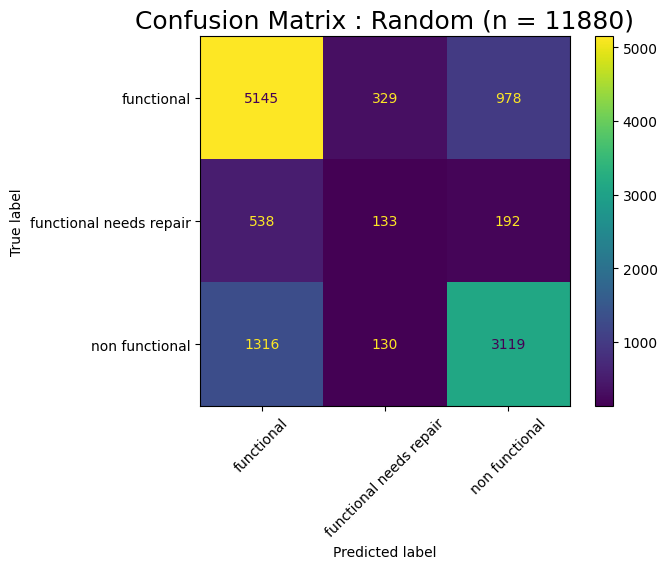

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final2, cmap=plt.cm.viridis)
plt.title(f"Confusion Matrix : Random (n = {len(y_test)})", fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [31]:
import requests
import json

In [32]:
import pickle
with open('model.pkl','wb') as pickle_file:
    pickle.dump(pipe_random, pickle_file)

In [55]:
model = pickle.load(open('flask_app/model/model.pkl', 'rb'))

In [56]:
y_pred = model.predict(X_test1)

print(y_pred)

['functional']


c:\ProgramData\Anaconda3\envs\project3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
